Index(['danceability', 'energy', 'loudness', 'acousticness', 'valence',
       'tempo'],
      dtype='str')
--- 5번 노래의 장르 예측 결과 ---
Action             40.155431
Drama              38.883665
Thriller           36.469091
Comedy             34.636166
Crime              27.712510
Adventure          27.035696
Science Fiction    19.128259
Fantasy            17.922986
Mystery            17.667957
Romance            16.809941
Music              11.943953
Animation          11.694974
Horror              9.442193
Foreign             6.480182
Documentary         5.121722
History             3.549278
Western             1.970807
TV Movie            1.597668
War                 1.582130
Name: 5, dtype: float64
전체 평균 Log Loss: 3.1342


C:\Users\jia11\miniconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:310: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


Top-1 | Micro F1: 0.256 | Macro F1: 0.089 | weighted f1 0.212
Top-2 | Micro F1: 0.324 | Macro F1: 0.140 | weighted f1 0.287
Top-3 | Micro F1: 0.350 | Macro F1: 0.163 | weighted f1 0.329
Top-5 | Micro F1: 0.363 | Macro F1: 0.194 | weighted f1 0.384
Hit@1: 0.407
Hit@2: 0.573
Hit@3: 0.698
Hit@5: 0.846


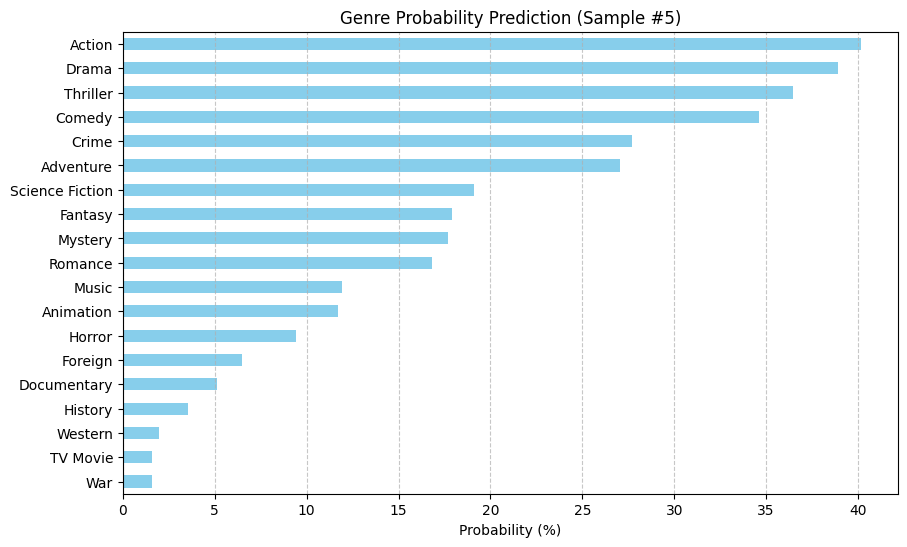

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


music_df = pd.read_csv('../../data/processed/ost_list_endgame.csv')
music_df_iloc = music_df


X = music_df_iloc[['danceability', 'energy', 'loudness', 'acousticness', 'valence', 'tempo']]
print(X.columns )
y = music_df_iloc.iloc[:, 2:22].drop(columns=['Family'])

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

rf_clf = RandomForestClassifier(
    max_depth=15, 
    n_estimators=200, 
    max_features='sqrt', 
    random_state=42,
    class_weight='balanced'
)

rf_clf.fit(X_train, y_train)
rf_clf.score(X_train, y_train), rf_clf.score(X_test, y_test)

# 특성 중요도
feat_impt_ser = pd.Series(rf_clf.feature_importances_, index=X.columns).sort_values(ascending=False)
# 장르별 예측
prob_result = rf_clf.predict_proba(X_test)

# y컬럼 == 장르
genre_names = y.columns
proba_list = []

# 장르가 여러개니 장르일 확률
for i in range(len(genre_names)):
    proba_list.append(prob_result[i][:, 1])

# 그래프로 하기 위해 데이터프레임으로
proba_df = pd.DataFrame(np.array(proba_list).T, columns=genre_names)

# 노래 테스트 장르별 확률 확인 (퍼센트로 변환)
sample_index = 5
sample_proba = proba_df.iloc[sample_index] * 100
print(f"--- {sample_index}번 노래의 장르 예측 결과 ---")
print(sample_proba.sort_values(ascending=False))

# 모델 맞는지 예측
current_log_loss = log_loss(y_test, proba_df)
print(f"전체 평균 Log Loss: {current_log_loss:.4f}")

y_pred = rf_clf.predict(X_test)

def top_n_predict(proba_df, N):
    y_pred = np.zeros_like(proba_df.values)

    for i in range(len(proba_df)):
        top_n_idx = np.argsort(proba_df.iloc[i].values)[-N:]
        y_pred[i, top_n_idx] = 1

    return y_pred


# 여기 예측 부터 유의미함
# top 1 2 3 5까지 허용 (어디까지가 적당한지 보기 위해서)
for N in [1, 2, 3, 5]:
    y_pred_topN = top_n_predict(proba_df, N)

    # 확률이긴 하지만 다중 분류?이기 때문에 fl_score
    # micro가 제일 유의미 클래스 간 샘플 수가 크게 다를 때 유리
    micro_f1 = f1_score(y_test.values, y_pred_topN, average='micro')
    weighted_f1 = f1_score(y_test.values, y_pred_topN, average='weighted')
    macro_f1 = f1_score(y_test.values, y_pred_topN, average='macro')

    print(f"Top-{N} | Micro F1: {micro_f1:.3f} | Macro F1: {macro_f1:.3f} | weighted f1 {weighted_f1:.3f}")


# 상위 k개 장르 안에 실제 장르가 하나라도 들어있을 확률
def hit_at_k(y_true, y_proba, k):
    topk_idx = np.argsort(y_proba, axis=1)[:, -k:]
    hits = 0
    for i in range(len(y_true)):
        if np.any(y_true[i, topk_idx[i]] == 1):
            hits += 1
    return hits / len(y_true)

for k in [1, 2, 3, 5]:
    print(f"Hit@{k}: {hit_at_k(y_test.values, proba_df.values, k):.3f}")


plt.figure(figsize=(10, 6))
sample_proba.sort_values().plot(kind='barh', color='skyblue')
plt.xlabel('Probability (%)')
plt.title(f'Genre Probability Prediction (Sample #{sample_index})')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [14]:
import joblib

joblib.dump(rf_clf, 'rf_ost_genre_model.pkl')

['rf_ost_genre_model.pkl']

In [6]:
#!pip install xgboost

In [7]:
#xgboost
from xgboost import XGBClassifier
from sklearn.multiclass import OneVsRestClassifier

xgb_base = XGBClassifier(
    n_estimators=300,
    max_depth=5,
    learning_rate=0.05,
    subsample=0.8,
    colsample_bytree=0.8,
    objective='binary:logistic',
    eval_metric='logloss',
    random_state=42,
    n_jobs=-1
)

model = OneVsRestClassifier(xgb_base)

Micro F1: 0.4685760667903525
Macro F1: 0.17906325377736498
Log Loss: 3.5031328012415273
Top-1 | Micro F1: 0.336 | Macro F1: 0.067 | weighted f1 0.241
Top-2 | Micro F1: 0.464 | Macro F1: 0.107 | weighted f1 0.313
Top-3 | Micro F1: 0.470 | Macro F1: 0.163 | weighted f1 0.381
Top-5 | Micro F1: 0.421 | Macro F1: 0.205 | weighted f1 0.414


C:\Users\jia11\miniconda3\envs\study\Lib\site-packages\sklearn\metrics\_classification.py:310: UserWarning: The y_prob values do not sum to one. Make sure to pass probabilities.
  warnings.warn(


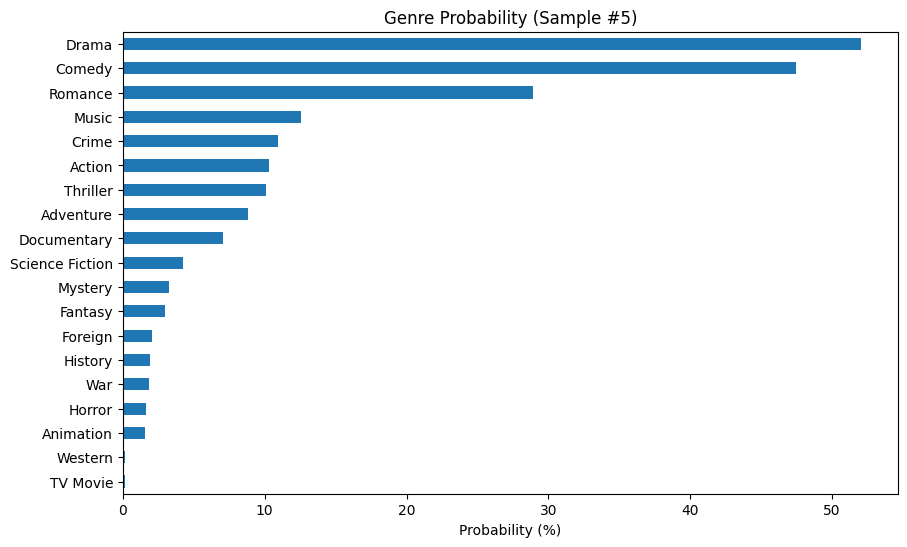

In [8]:
model.fit(X_train, y_train)

proba = model.predict_proba(X_test)
proba_df = pd.DataFrame(proba, columns=y.columns)



threshold = 0.2
y_pred = (proba_df >= threshold).astype(int)

from sklearn.metrics import f1_score, log_loss

print("Micro F1:", f1_score(y_test, y_pred, average='micro'))
print("Macro F1:", f1_score(y_test, y_pred, average='macro'))
print("Log Loss:", log_loss(y_test, proba_df))

def topk_f1_scores(y_true, y_proba, k):
    """
    y_true : np.array (n_samples, n_classes)  # 원핫 정답
    y_proba: np.array (n_samples, n_classes)  # 예측 확률
    k      : int (Top-K)
    """

    # Top-K 인덱스 구하기
    topk_idx = np.argsort(y_proba, axis=1)[:, -k:]

    # Top-K를 원핫 예측으로 변환
    y_pred_topk = np.zeros_like(y_proba, dtype=int)
    for i in range(y_proba.shape[0]):
        y_pred_topk[i, topk_idx[i]] = 1

    # F1 계산
    micro = f1_score(y_true, y_pred_topk, average='micro')
    macro = f1_score(y_true, y_pred_topk, average='macro')
    weighted = f1_score(y_true, y_pred_topk, average='weighted')

    return micro, macro, weighted


# top 1 2 3 5까지 허용 (어디까지가 적당한지 보기 위해서)
y_true = y_test.values
y_proba = proba_df.values

for k in [1, 2, 3, 5]:
    micro, macro, weighted = topk_f1_scores(y_true, y_proba, k)
    print(f"Top-{k} | Micro F1: {micro:.3f} | Macro F1: {macro:.3f} | weighted f1 {weighted:.3f}")


sample_index = 5
sample_proba = proba_df.iloc[sample_index] * 100

sample_proba.sort_values().plot(
    kind='barh', figsize=(10,6)
)
plt.title(f"Genre Probability (Sample #{sample_index})")
plt.xlabel("Probability (%)")
plt.show()


In [9]:
#import joblib

#joblib.dump(model, 'xgb_genre_model.pkl')

['xgb_genre_model.pkl']

샘플 125914번 노래 제목: I Was Dead
Music              54.866995
Science Fiction    30.145178
Action             27.181957
Adventure          24.388308
Drama              22.805000
Comedy             20.451925
Horror             16.686040
History            15.873605
Mystery            14.759428
War                14.179064
Romance            11.415414
Foreign            10.608053
Western             9.509744
Thriller            8.695548
Crime               8.496130
TV Movie            7.011586
Fantasy             4.861947
Documentary         4.198444
Animation           1.772916
Name: 125914, dtype: float64
Drama              0.228050
Comedy             0.204519
Romance            0.114154
Action             0.271820
Crime              0.084961
Thriller           0.086955
Music              0.548670
Adventure          0.243883
Documentary        0.041984
Foreign            0.106081
Fantasy            0.048619
Horror             0.166860
Mystery            0.147594
Science Fiction    0.301452

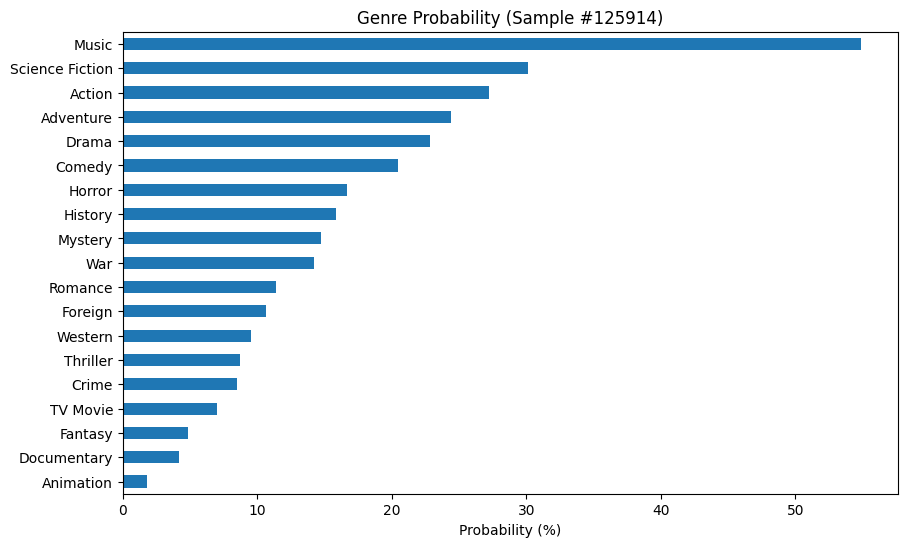

In [ ]:
import pandas as pd
import numpy as np
import joblib
import matplotlib.pyplot as plt
test_df = pd.read_csv('../../data/raw/song_track.csv')

X_test_new = test_df[
    ['danceability', 'energy', 'loudness', 'acousticness', 'valence', 'tempo']
]

rf_clf = joblib.load('../../model/rf_ost_genre_model.pkl')

prob_result = rf_clf.predict_proba(X_test_new)

genre_names = ['Drama', 'Comedy', 'Romance', 'Action', 'Crime', 'Thriller',             
'Music', 'Adventure', 'Documentary', 'Foreign', 'Fantasy', 'Horror',       
'Mystery', 'Science Fiction', 'War', 'Animation', 'History', 'Western', 'TV Movie']
proba_list = []

for i in range(len(genre_names)):
    proba_list.append(prob_result[i][:, 1])

proba_df = pd.DataFrame(
    np.array(proba_list).T,
    columns=genre_names
)

sample_index = 125914  # 테스트 CSV의 6번째 행

track_name = test_df.iloc[sample_index]['track_name']
print(f"샘플 {sample_index}번 노래 제목: {track_name}")

sample_proba = proba_df.iloc[sample_index] * 100
print(sample_proba.sort_values(ascending=False))
print(proba_df.iloc[sample_index])

sample_proba.sort_values().plot(
    kind='barh', figsize=(10,6)
)
plt.title(f"Genre Probability (Sample #{sample_index})")
plt.xlabel("Probability (%)")
plt.show()
